In [9]:
# =============================
# Flight Price Prediction - Model Comparison + Feature Importance + Save Best Model
# =============================

import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb


In [11]:
# 1. Load Dataset
file_path = (r"C:\Users\Dell\Desktop\Group_2\airlines_flights_data.csv")
df = pd.read_csv(file_path)

In [13]:
# Drop unnecessary columns
df_model = df.drop(columns=["index", "flight"])

In [15]:
# Features and target
X = df_model.drop(columns=["price"])
y = df_model["price"]

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# 2. Preprocessing

In [20]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# 3. Models to Compare

In [23]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# 4. Training & Evaluation

In [26]:
results = {}
trained_pipelines = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MSE": mse, "RMSE": rmse, "R2": r2}
    trained_pipelines[name] = pipeline

Training LinearRegression...
Training RandomForest...
Training GradientBoosting...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 37
[LightGBM] [Info] Start training from score 20903.770521


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# 5. Results

In [28]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison Results:")
print(results_df)


Model Comparison Results:
                           MSE         RMSE        R2
LinearRegression  4.553512e+07  6747.971677  0.911748
RandomForest      7.583111e+06  2753.744926  0.985303
GradientBoosting  2.435877e+07  4935.460361  0.952790
XGBoost           1.162403e+07  3409.403467  0.977471
LightGBM          1.497845e+07  3870.200721  0.970970


# 6. Feature Importance (from best tree-based model)

In [30]:
best_model_name = results_df.loc[["RandomForest", "XGBoost", "LightGBM"]]["R2"].idxmax()
print(f"\nBest model for feature importance: {best_model_name}")

best_pipeline = trained_pipelines[best_model_name]
model = best_pipeline.named_steps["model"]


Best model for feature importance: RandomForest


In [31]:
# Get feature names after encoding
encoder = best_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
encoded_cat_features = encoder.get_feature_names_out(categorical_cols)
all_features = list(encoded_cat_features) + numeric_cols

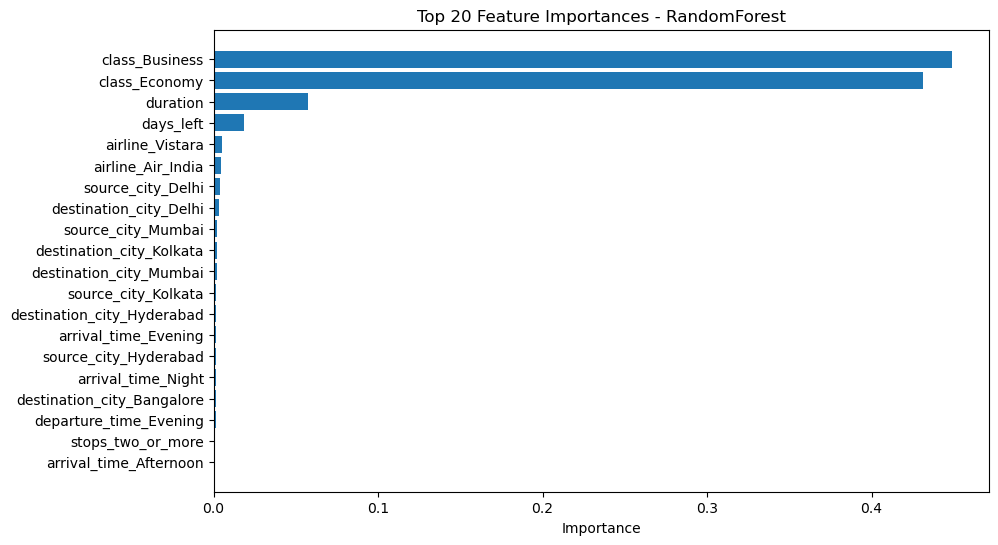

In [32]:
# Get importances
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        "feature": all_features,
        "importance": importances
    }).sort_values(by="importance", ascending=False).head(20)  # top 20
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
    plt.gca().invert_yaxis()
    plt.title(f"Top 20 Feature Importances - {best_model_name}")
    plt.xlabel("Importance")
    plt.show()

# 7. Save Best Model

In [34]:
model_filename = f"best_flight_price_model_{best_model_name}.pkl"
joblib.dump(best_pipeline, model_filename)
print(f"\n✅ Best model saved as: {model_filename}")


✅ Best model saved as: best_flight_price_model_RandomForest.pkl
